# **Downloading the data**

In [ ]:
!git clone "https://github.com/Ayma-n/dl-fp"

Cloning into 'dl-fp'...
remote: Enumerating objects: 294, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 294 (delta 88), reused 95 (delta 41), pack-reused 147
Receiving objects: 100% (294/294), 3.54 MiB | 6.06 MiB/s, done.
Resolving deltas: 100% (171/171), done.


In [ ]:
!cd /content/dl-fp/ && git pull && cd ..

Already up to date.


# Dependencies

In [ ]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
!pip install pycocotools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 2.3 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-n96hi__i
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-n96hi__i
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_

# Preprocessing Dependencies


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q "/content/drive/MyDrive/2nd_year/2nd_semester/DL/Final project/Deep Learning FP/Dataset/annotations_trainval2017.zip" -d "/content/Unzipped/"

In [ ]:
!unzip -q "/content/drive/MyDrive/2nd_year/2nd_semester/DL/Final project/Deep Learning FP/Final Notebooks/Final Datasets/SMALL_train_offline_preprocess.zip" -d "/content/Unzipped/"

In [ ]:
# Constant for batch size
BATCH_SIZE = 16

In [ ]:
#UP TO DATE PRE-PROCESSING
import os
import tensorflow as tf
os.chdir("/content/dl-fp/")
import preprocess as pp

images_path = "/content/Unzipped/train_offline_preprocess/"
annotations_path = "/content/Unzipped/annotations/captions_train2017.json"
dataset_train, dataset_valid = pp.load_coco_data(images_path, annotations_path, True)

ds_train = pp.get_64x64_images_and_5_text_embeddings(dataset_train)
ds_train_batched = ds_train.shuffle(buffer_size=512).batch(BATCH_SIZE, drop_remainder=True)

ds_valid = pp.get_64x64_images_and_5_text_embeddings(dataset_valid)
ds_valid_batched = ds_train.shuffle(buffer_size=512).batch(BATCH_SIZE, drop_remainder=True)

100%|███████████████████████████████████████| 338M/338M [00:04<00:00, 83.8MiB/s]


loading annotations into memory...
Done (t=0.93s)
creating index...
index created!
ids to get:  [363071, 254008, 31470, 46255, 201083, 203463, 496300, 561384, 324591, 132183, 59789, 436797, 307206, 90370, 483742, 489622, 477826, 81676, 167369, 177036, 289275, 118852, 565144, 84859, 155624, 429184, 3348, 414046, 428305, 305585, 571944, 43371, 564898, 289569, 543665, 364719, 430157, 276801, 177349, 432172, 205380, 142660, 179932, 498297, 477047, 248169, 274277, 520883, 361309, 214764, 345937, 581466, 532145, 578519, 146951, 395019, 34674, 78900, 405547, 286083, 488160, 167901, 561615, 484341, 45828, 474775, 326978, 577838, 313134, 319866, 458401, 144519, 36218, 535804, 572355, 512696, 39925, 354410, 286253, 407040, 195862, 270581, 179200, 386712, 253362, 145855, 118895, 261155, 395958, 499302, 24788, 553488, 58933, 89101, 96280, 375869, 345973, 347179, 491850, 454577, 79545, 83587, 39017, 574453, 88419, 57498, 406977, 437167, 37563, 376024, 49187, 149220, 37697, 205940, 39864, 308405, 83

Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead



Successfully initialized!


Instructions for updating:
Use tf.identity with explicit device placement instead.


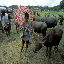

(1, 512)


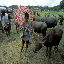

(1, 512)


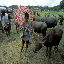

(1, 512)


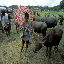

(1, 512)


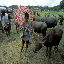

(1, 512)


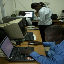

(1, 512)


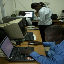

(1, 512)


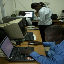

(1, 512)


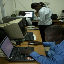

(1, 512)


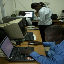

(1, 512)


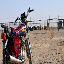

(1, 512)


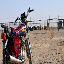

(1, 512)


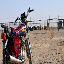

(1, 512)


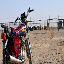

(1, 512)


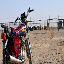

(1, 512)


In [ ]:
for img, clip_embeddings in ds_train.take(15):
  image_to_show = tf.keras.preprocessing.image.array_to_img(img)
  display(image_to_show)
  print(clip_embeddings.shape)

In [ ]:
import tensorflow as tf
import torch
import os
import matplotlib.pyplot as plt
os.chdir("/content/dl-fp/")
import clip_wrapper

class ClipCVAE(tf.keras.Model):
  def __init__(self, input_shape,  latent_dim, dropout_rate=0.3):
    super(ClipCVAE, self).__init__()
    self.latent_dim = latent_dim
    self.dropout_rate = dropout_rate
    self.shape_input = input_shape

    #Dense layer used to shrink the embedding before inputing it in the decoder
    self.embedding_shrinker = tf.keras.layers.Dense(32)

    #First part of the encoder before embedding concatenation
    self.encoder_part1= tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=self.shape_input, name="encoder_part1_inputlayer"),
            tf.keras.layers.Conv2D(256, 3, strides=2, padding="same", kernel_initializer=tf.keras.initializers.HeNormal(), name="conv2d1"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Conv2D(256,5, strides=2, padding="same", kernel_initializer=tf.keras.initializers.HeNormal(), name="conv2d2"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Conv2D(128, 3, strides=2, padding="same", kernel_initializer=tf.keras.initializers.HeNormal(), name="conv2d3"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Conv2D(128, 3, strides=2, padding="same", kernel_initializer=tf.keras.initializers.HeNormal(), name="conv2d4"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Flatten()])

    self.encoder_part2 = tf.keras.Sequential([
            tf.keras.layers.Dense(2048, kernel_initializer=tf.keras.initializers.HeNormal(), activation = "leaky_relu"),
            tf.keras.layers.Dense(2048, kernel_initializer=tf.keras.initializers.HeNormal(), activation="leaky_relu"),
            tf.keras.layers.Dense(1024, kernel_initializer=tf.keras.initializers.HeNormal()),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU()

        ]
    )

    self.mu = tf.keras.layers.Dense(self.latent_dim, kernel_initializer=tf.keras.initializers.HeNormal())
    self.logv = tf.keras.layers.Dense(self.latent_dim, kernel_initializer=tf.keras.initializers.HeNormal())

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.Dense(8 * 8 * 256, kernel_initializer=tf.keras.initializers.HeNormal()),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Reshape((8,8,256)),
            tf.keras.layers.Conv2DTranspose(256, 3, strides=2, padding="same", kernel_initializer=tf.keras.initializers.HeNormal()),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Conv2DTranspose(256, 5, strides=2, padding="same", kernel_initializer=tf.keras.initializers.HeNormal()),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Conv2DTranspose(128, 5, strides=2, padding="same", kernel_initializer=tf.keras.initializers.HeNormal()),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Conv2DTranspose(128, 3, strides=1, padding="same", kernel_initializer=tf.keras.initializers.HeNormal()),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Conv2DTranspose(32, 5, strides=1, padding="same", kernel_initializer=tf.keras.initializers.HeNormal()),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Conv2D(3, 5, strides=1, padding="same", activation="sigmoid", kernel_initializer=tf.keras.initializers.HeNormal())
        ]
    )

  #Loss combining Binary Cross entropy, KL Divergence and Structural Similarity
  def compute_loss(self, inputs, reconstructed, logv, mu):
    inputs, _ = inputs
    reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.keras.losses.binary_crossentropy(inputs, reconstructed)))
    ssim_loss = 1 - tf.reduce_mean(tf.image.ssim(inputs, reconstructed, max_val=1.0))
    kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + logv - tf.square(mu) - tf.exp(logv)))
    total_loss = reconstruction_loss + 0.5 * kl_loss + 0.1 * ssim_loss
    return total_loss / BATCH_SIZE

  def call(self, args, training=False):
    x, embedding = args
    embedding = tf.squeeze(embedding, axis=1)

    # First part of the encoding
    e1 = self.encoder_part1(x)
    e1_w_embedding = tf.concat([e1, embedding], axis=-1)

    # Go through part 2 of encoder
    e2 = self.encoder_part2(e1_w_embedding)

    # Mu and Logv
    mu = self.mu(e2)
    logv = self.logv(e2)

    # Sample Z (reparameterization trick)
    sigma = tf.math.sqrt(tf.math.exp(logv))
    eps = tf.random.normal([BATCH_SIZE, self.latent_dim])
    z = mu + tf.multiply(sigma, eps)

    if training:
      z = tf.nn.dropout(z, rate=self.dropout_rate)

    embedding = self.embedding_shrinker(embedding)
    # Concatenate z with embedding again
    z_w_embedding = tf.concat([z, embedding], axis=-1)

    # Decode!
    res = self.decoder(z_w_embedding)

    return res, mu, logv

  # Called when .fit is called
  def train_step(self, data):
      with tf.GradientTape() as tape:
          reconstruction, mu, logv = self(data, training=True)
          loss = self.compute_loss(data, reconstruction, logv, mu)
      grads = tape.gradient(loss, self.trainable_variables)
      self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
      return {'train loss': loss}

  # Called at each epoch when .fit is called (validation loss)
  def test_step(self, data):
    reconstruction, mu, logv = self(data, training=False)
    loss = self.compute_loss(data, reconstruction, logv, mu)
    return {'valid loss': loss}

  #Visualisation
  def show_image(self, capt):
    z = tf.random.normal(shape=[1, self.latent_dim])
    encoding = clip_wrapper.get_text_encoding(capt)
    encoding = self.embedding_shrinker(encoding)
    z = tf.concat([z, encoding], axis=-1)
    img = self.decoder(z).numpy()[0]
    plt.imshow(img)

In [ ]:
# Make directory for checkpoints and weights. This will simply error out if it already exists
!mkdir /content/dl-fp/ckpts
!mkdir /content/dl-fp/weights

In [ ]:
# Prepare for checkpoints
chk_pt = tf.keras.callbacks.ModelCheckpoint(
    "/content/dl-fp/ckpts/model_64_txt_embeds_ckpt",
    monitor="val_valid",
    verbose=0,
    save_best_only=False,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch",
    initial_value_threshold=None,
)

In [ ]:
cvae = ClipCVAE(input_shape=(64, 64, 3), latent_dim=128, dropout_rate=0.3)
cvae.compile(optimizer=tf.keras.optimizers.Adam(0.0005))
cvae.fit(ds_train_batched, epochs=10, batch_size=BATCH_SIZE, validation_data=ds_valid_batched, callbacks=[chk_pt])
cvae.save_weights("/content/dl-fp/weights/64_txt_embeds.h5")

Epoch 1/10
797/797 [==============================] - 261s 307ms/step - train loss: 166986774.5527 - val_valid loss: 2943.4148
Epoch 2/10
797/797 [==============================] - 238s 295ms/step - train loss: 5311.7652 - val_valid loss: 3403.6392
Epoch 3/10
797/797 [==============================] - 237s 294ms/step - train loss: 3767.7801 - val_valid loss: 3367.7219
Epoch 4/10
797/797 [==============================] - 238s 295ms/step - train loss: 3440.7487 - val_valid loss: 2535.9270
Epoch 5/10
797/797 [==============================] - 237s 294ms/step - train loss: 3139.6447 - val_valid loss: 2577.7075
Epoch 6/10
797/797 [==============================] - 287s 356ms/step - train loss: 2878.1951 - val_valid loss: 2618.8403
Epoch 7/10
797/797 [==============================] - 234s 289ms/step - train loss: 2708.3230 - val_valid loss: 2541.7783
Epoch 8/10
797/797 [==============================] - 235s 292ms/step - train loss: 2687.3049 - val_valid loss: 2526.9875
Epoch 9/10
797/797 

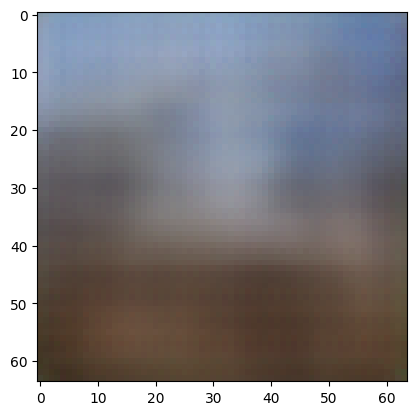

In [ ]:
#THIS CELL SHOULD BE RUN IF WHEIGHTS ALREADY EXISTS
#existing weights can be found in the "weights" folder

# Prediction
vae = ClipCVAE(input_shape=(64, 64, 3), latent_dim=128)
example_input = tf.random.normal((16, 64, 64, 3))
example_embedding = tf.random.normal((16, 1, 512))

# Dummy prediction to initialize model and be able to load weights
im = vae((example_input, example_embedding))[0]

vae.load_weights("/content/drive/MyDrive/2nd_year/2nd_semester/DL/Final project/Deep Learning FP/Final Notebooks/Weights/cvae_weights_64x64_imemb_small_og_dropout.h5")
vae.show_image("cow in moutain with sky")

In [ ]:
# Save weights to Google Drive
!cp "/content/dl-fp/weights/64_txt_embeds.h5" "/content/drive/MyDrive/Deep Learning FP/Final Notebooks/Weights/cvae_weights_64x64_txtemb5_small_og.h5"